Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 6: Support Vector Machines

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

This notebook is structured as follows:<br>
Classification with Support Vector Machines

[Part 1 - Linear Decision Boundary Problem](#pt1)<br>
1. [Exploratory Data Analysis](#eda)
2. [Linear SVMs with sklearn](#linear)
3. [Kernelized (non-linear) SVMs with sklearn](#radial)

[Part 2 - Non-linear Decision Boundary Problem](#pt2)<br>
1. [Exploratory Data Analysis](#eda2)
2. [Kernelized (non-linear) SVMs with sklearn](#radial2)
3. [Model Selection: $k$-Fold Cross Validation with Grid Search](#ms)

[Part 3 - Spam Classification](#pt3)<br>

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

<a id="Part1"></a>
# Support Vector Machines

Prompt:<br>
    
In this exercise, you will be using support vector machines (SVMs) to build a spam classifier.

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support vector machines to build a spam classifier.
***

OK. Let's dive into the data and begin building some SVMs!

<a id="pt1"></a>
# Linear Decision Boundary Problem
<a id="eda"></a>
# Exploratory Data Analysis

In [2]:
raw_data = loadmat('ex6/ex6data1.mat')
data = pd.DataFrame(raw_data['X'], columns = ['X1','X2'])

In [3]:
#add y data to the data frame
data['y'] = raw_data['y']

In [4]:
positive = data[data['y']==1]
negative = data[data['y']==0]

In [5]:
data.head()

,X1,X2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
X1    51 non-null float64
X2    51 non-null float64
y     51 non-null uint8
dtypes: float64(2), uint8(1)
memory usage: 947.0 bytes


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,51.0,2.268780,0.928531,0.086405,1.57255,2.2753,2.95505,4.0150
X2,51.0,3.132512,0.753256,1.617700,2.63600,3.0709,3.53140,4.6162
y,51.0,0.411765,0.497050,0.000000,0.00000,0.0000,1.00000,1.0000


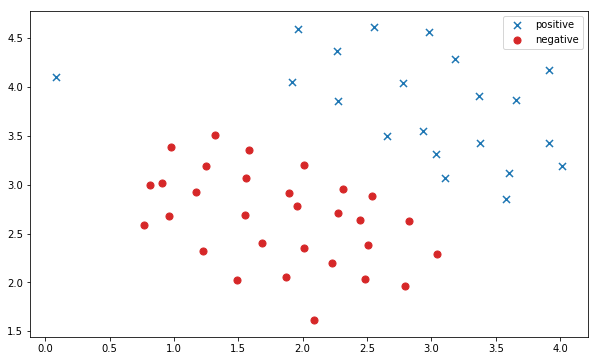

In [8]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(positive['X1'],positive['X2'], s=50, marker='x',label='positive')
ax.scatter(negative['X1'],negative['X2'], color=cp[3], s=50, marker='o',label='negative')
ax.legend()
plt.show()

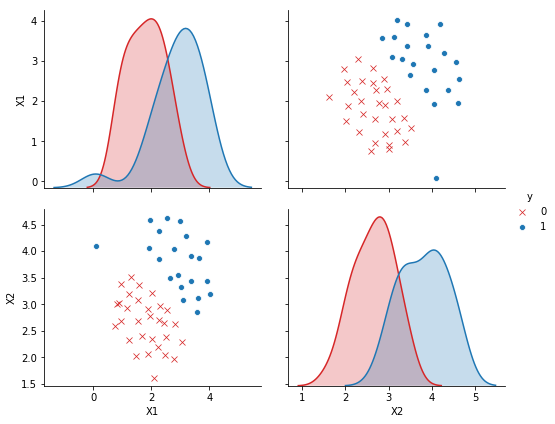

In [9]:
#have to cast the data into a 'category' type to get it to plot with seaborn's pairplot
data.iloc[:,-1] = data.iloc[:,-1].astype('category')

sns.pairplot(data, vars=["X1", "X2"], hue="y", \
             palette={0:cp[3], 1:cp[0]}, height=3, aspect=1.2, markers=["x", "o"])

In [10]:
# cast the y data back to int type
data.iloc[:,-1] = data.iloc[:,-1].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
X1    51 non-null float64
X2    51 non-null float64
y     51 non-null int64
dtypes: float64(2), int64(1)
memory usage: 1.3 KB


<a id="linear"></a>
# Linear SVMs with sklearn

In [11]:
lin_svm1 = svm.LinearSVC(C=1, loss='hinge', max_iter=1000).fit(data[['X1','X2']], data['y'])
lin_svm1.score(data[['X1','X2']], data['y'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9803921568627451

All we need are two lines of code and already we have a 98% accurate classifier.

In [12]:
lin_svm2 = svm.LinearSVC(C=.1, loss='hinge', max_iter=1000).fit(data[['X1', 'X2']], data['y'])
lin_svm2.score(data[['X1', 'X2']], data['y'])

0.6862745098039216

Text(0.5, 1.0, 'SVM (C=1) Decision Confidence')

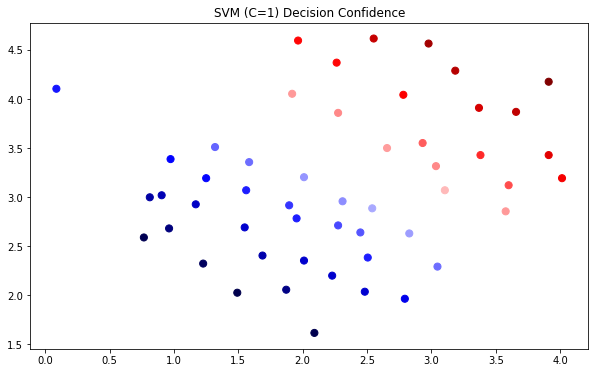

In [13]:
data['SVM1 Confidence'] = lin_svm1.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM1 Confidence'], cmap='seismic')
ax.set_title('SVM (C=1) Decision Confidence')

Overall it does great! The accuracy is 98%. To be honest, the data is nicely separated and it should have quite a high accuracy for any half decent classifier. However, notice that the outlying data point (near [0,4]) is misclassified?  A linear kernel for the svm will have trouble with that data point. 

In addition, notice the fading of the color near the boundary. That's becuse the svm model is not too confident about those predictions. In this graph the color scale is the "decision function." The decision function provides the confidence that the data point belongs to that class and is not a probability of belonging to a class. Slightly confusing, I know. Note that LinearSVC() does not have a predict_proba method but the (non-linear) svm.SVC() does. For more information about getting probabilities, see the sklearn documentation on [support vector machines](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities). I also found [this stack overflow page](https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python) helpful.

Even though we are using a linear model (with linear boundary), regularization can still have an impact on the quality of our model's performance. Let's take a look at what happens if we decrease the inverse regularization parameter $C$ (i.e. increase regularization).

Text(0.5, 1.0, 'SVM (C=0.1) Decision Confidence')

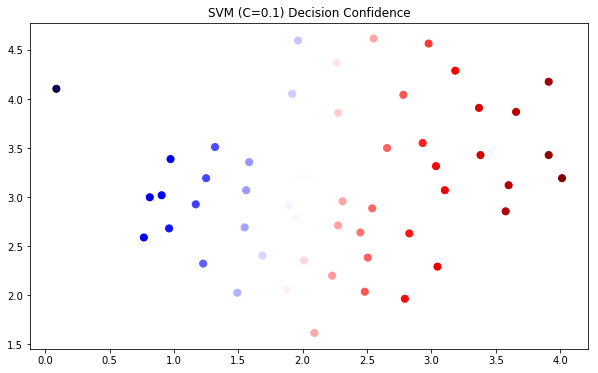

In [14]:
data['SVM2 Confidence'] = lin_svm2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM2 Confidence'], cmap='seismic')
ax.set_title('SVM (C=0.1) Decision Confidence')

Woah! Crank up the regularization (decrease $C$) and the model has high bias (no longer sensitive to the X1 and X2 features).

<a id="radial"></a>
# Kernelized (non-linear) SVMs with sklearn

In [15]:
svc = svm.SVC(gamma=1) #default hyperparameters, C=1, kernel=rbf
svc.fit(data[['X1','X2']], data['y'])
svc.score(data[['X1','X2']], data['y'])

1.0

In [16]:
svm.SVC?

Text(0.5, 1.0, 'SVC Radial Kernel (C=1, gamma=1) Decision Confidence')

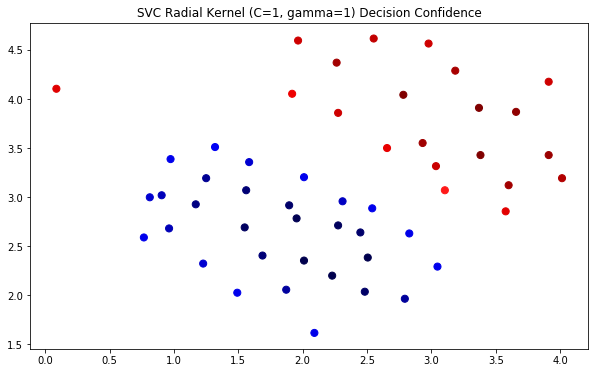

In [17]:
data['SVC Confidence'] = svc.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVC Confidence'], cmap='seismic')
ax.set_title('SVC Radial Kernel (C=1, gamma=1) Decision Confidence')

<a id="pt2"></a>
# Non-Linear Decision Boundary Problem
<a id="eda2"></a>
# Exploratory Data Analysis

In [18]:
raw_data = loadmat('ex6/ex6data2.mat')

In [19]:
data = pd.DataFrame(raw_data['X'],columns=['X1','X2'])
data['y']=raw_data['y']

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 3 columns):
X1    863 non-null float64
X2    863 non-null float64
y     863 non-null uint8
dtypes: float64(2), uint8(1)
memory usage: 14.4 KB


In [21]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,863.0,0.503414,0.254967,0.044931,0.292627,0.512673,0.699309,0.998848
X2,863.0,0.694304,0.158884,0.402632,0.557018,0.693713,0.830409,0.988596
y,863.0,0.556199,0.497120,0.000000,0.000000,1.000000,1.000000,1.000000


In [22]:
positive = data[data['y']==1]
negative = data[data['y']==0]

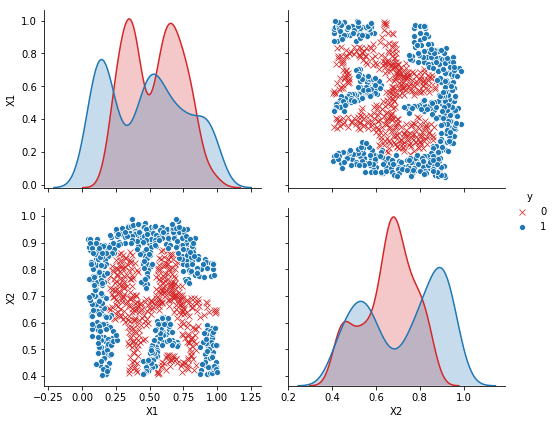

In [23]:
#have to cast the data into a 'category' type to get it to plot with seaborn's pairplot
data.iloc[:,-1] = data.iloc[:,-1].astype('category')

sns.pairplot(data, vars=["X1", "X2"], hue="y", \
             palette={0:cp[3], 1:cp[0]}, height=3, aspect=1.2, markers=["x", "o"])

In [24]:
# cast the y data back to int type
data.iloc[:,-1] = data.iloc[:,-1].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 3 columns):
X1    863 non-null float64
X2    863 non-null float64
y     863 non-null int64
dtypes: float64(2), int64(1)
memory usage: 20.3 KB


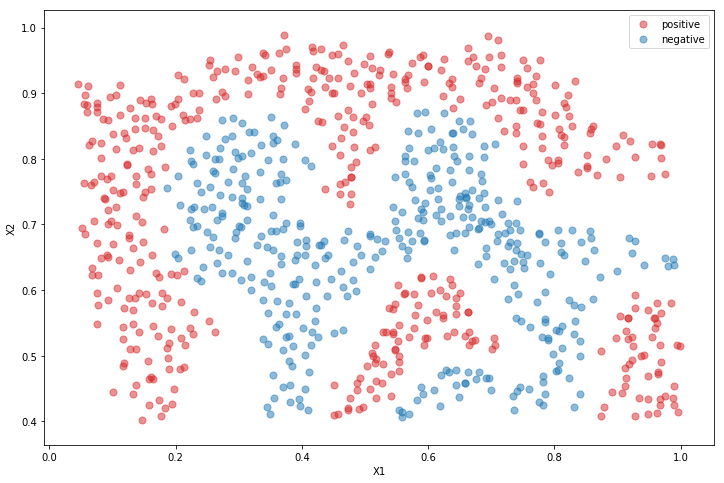

In [25]:
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'],positive['X2'], s=50, color=cp[3], label='positive', alpha=0.5)
ax.scatter(negative['X1'],negative['X2'], color=cp[0], s=50, marker='o',label='negative', alpha=0.5)
ax.legend()
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

<a id="radial2"></a>
# Kernelized (non-linear) SVMs with sklearn

We could of course build a non-linear boundary for a logistic regression classifier by generation polynomial features from X1 and X2. However, that's not so easy - refer back to example3.

Instead we'll us an SVM with the rbf (radial basis function) kernel. Conveniently, the svm.SVC() has a precict_proba() method and can provide us with the actual probabilities that a data point belongs to a class. I'll use this information to provide a color scale to the data so that it's easier to visualize how the model is performing. 

Let's start with the default parameters for svm.svc():<br>
$C$ = 1<br>
$\gamma$ = 1/n_features (i.e. some small number - this means a __wide__ radial function)

In [26]:
len(data)

863

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


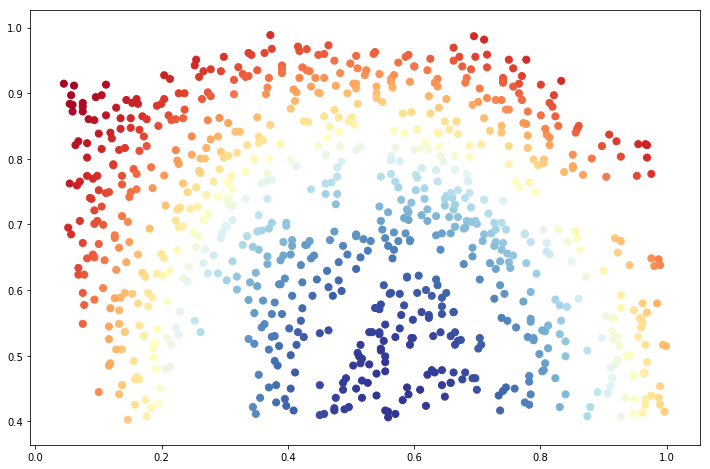

In [27]:
svc = svm.SVC(probability=True) # make sure to turn on the probability estimator
svc.fit(data[['X1', 'X2']], data['y'])

# assign the probabilities into the dataframe to use as the colormap
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0] 

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, marker='o', c=data['Probability'], cmap='RdYlBu')

Not a bad start. But this time the svm doesn't seem to be giving us quite the performance we're looking for. Just by eyeballing it, I would say that it seems to be underfitting. Let's decrease regularization (i.e. increase $C$).

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


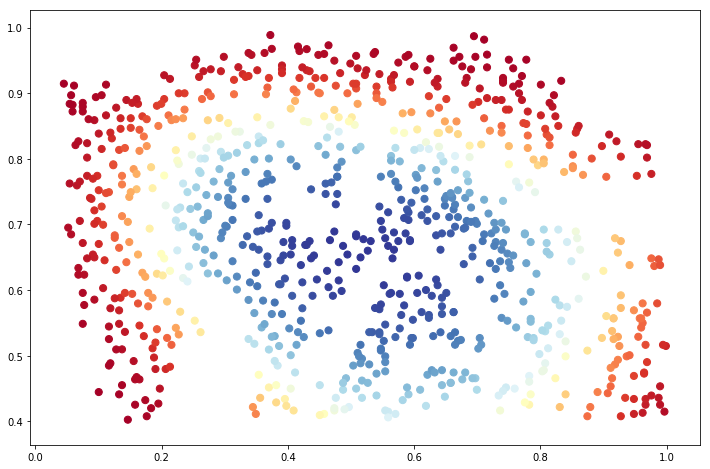

In [28]:
svc = svm.SVC(C=1000, probability=True) 
svc.fit(data[['X1', 'X2']], data['y'])
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, marker='o', c=data['Probability'], cmap='RdYlBu')

That's definitely better, but we're still misclassifying a lot of the data and it appears still to be underfitting. The next obvious parameter to play with is $\gamma$, which controls the spacial (in features space) width of the radial function which surrounds each data point. If we tighten that up then we might get a better non-linear boundary.

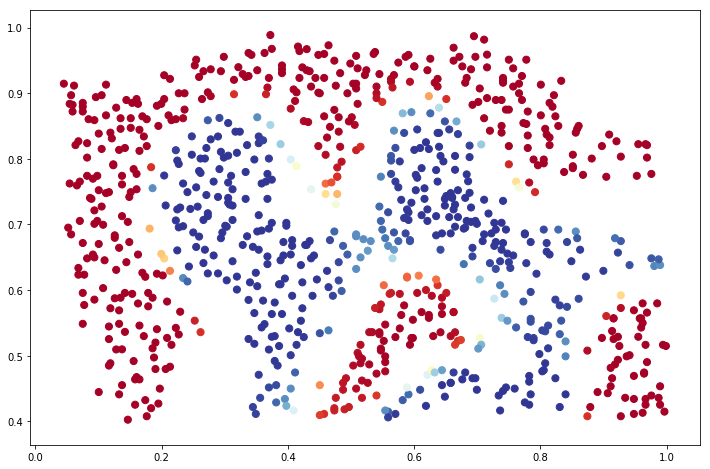

In [29]:
svc = svm.SVC(C=1000, gamma=10, probability=True) 
svc.fit(data[['X1', 'X2']], data['y'])
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, marker='o', c=data['Probability'], cmap='RdYlBu')

That did it! We tightened up the radial width for the kernel (i.e. increase gamma) and we found a model which appears to describe the data well.
<a id="ms"></a>
# Model Selection: $k$-Fold Cross Validation with Grid Search

What is a good approach for finding the best hyperparamters? We can see that with non-linear SVMs we have two parameters: regularization and kernel width. There are two standard approaches: 1) $k$-fold cross validation and 2) grid search. Or even better: use the two together. Check out the sklearn documentation on [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) and [tuning hyperparameters](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

The example prompt would like us to implement grid search manually. But let's not do that. Instead, let's use sklearn to do $k$-fold cross validation and grid search. These are extremely useful model selection/evaluation tools to know how to implement.


In [30]:
parameters = {'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100] }
svc = svm.SVC(kernel='rbf')
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(data[['X1', 'X2']], data['y'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
clf.best_params_

{'C': 10, 'gamma': 100}

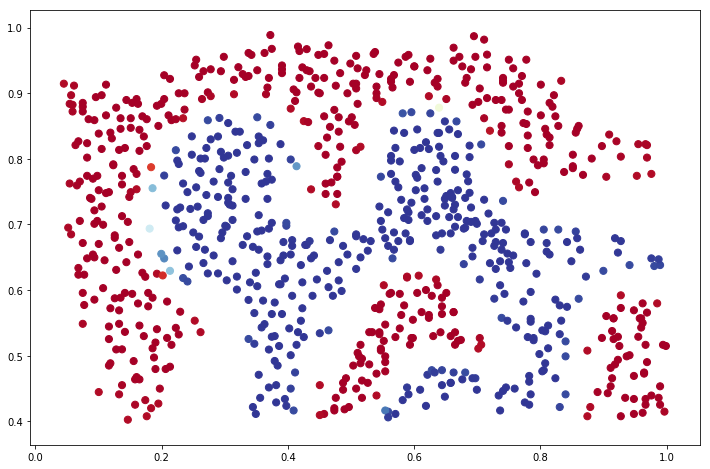

In [32]:
svc = svm.SVC(C=clf.best_params_['C'], gamma=clf.best_params_['gamma'], probability=True) 
svc.fit(data[['X1', 'X2']], data['y'])
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, marker='o', c=data['Probability'], cmap='RdYlBu')

Awesome! And super easy right?<br>
Let's be a bit more general with our model selection and do a more fined tuned comb over parameter space. Note that this will take way, way, way longer!

In [33]:
parameters = {'C': np.logspace(0,2,num=20), 'gamma': np.logspace(1,3,num=20) }
svc = svm.SVC(kernel='rbf')
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(data[['X1', 'X2']], data['y'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([  1.     ,   1.27427,   1.62378,   2.06914,   2.63665,   3.35982,
         4.28133,   5.45559,   6.95193,   8.85867,  11.28838,  14.3845 ,
        18.32981,  23.35721,  29.76351,  37.9269 ,  48.3293 ,  61.58482,
        78.476  , 100.     ]), 'gamma': array([  10.     ,   12.....29807,  233.57215,  297.63514,
        379.26902,  483.29302,  615.84821,  784.75997, 1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
clf.best_params_

{'C': 6.951927961775605, 'gamma': 69.51927961775606}

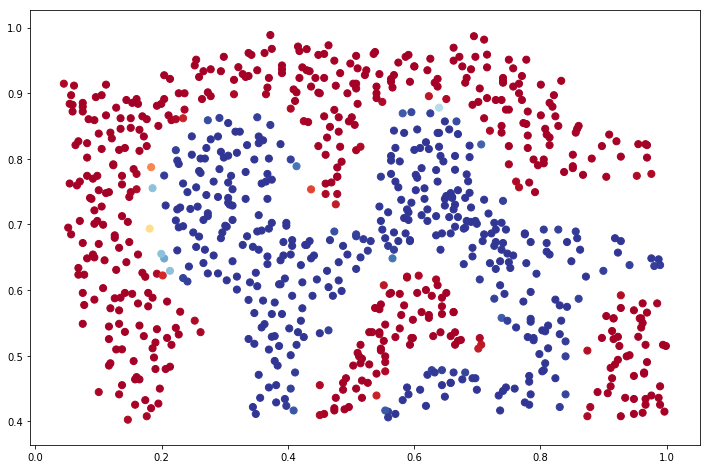

In [35]:
svc = svm.SVC(C=clf.best_params_['C'], gamma=clf.best_params_['gamma'], probability=True) 
svc.fit(data[['X1', 'X2']], data['y'])
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, marker='o', c=data['Probability'], cmap='RdYlBu')

In [36]:
### Model Evaluation of best-fit parameters from grid search with cross validation

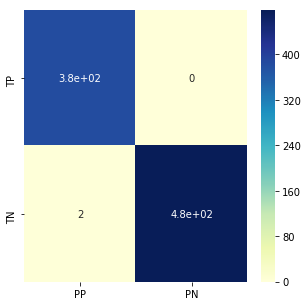

In [37]:
y_pred = svc.predict(data[['X1', 'X2']])
conf = confusion_matrix(data['y'], y_pred)
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [38]:
svc.score(data[['X1', 'X2']], data['y'])

0.9976825028968713

<a id="pt3"></a>
# Spam classification


In [39]:
spam_train = loadmat('ex6/spamTrain.mat')
spam_test = loadmat('ex6/spamTest.mat')

In [40]:
spam_train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

Already cleaned and normalized data. The matrix is a sparse array representing the embeddings of categorical data (words). No need to "explore" the data for this example. 

In [41]:
X_train = spam_train['X']
X_test = spam_test['Xtest']
y_train = spam_train['y'].ravel()
y_test = spam_test['ytest'].ravel()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

Each document has been converted to a vector with 1,899 dimensions corresponding to the 1,899 words in the vocabulary. The values are binary. 


In [42]:
svc = svm.SVC().fit(X_train, y_train)  # let's just start with the default paramters
acc_train = svc.score(X_train, y_train)
acc_test = svc.score(X_test, y_test)
print('Train Accuracy = {:3}%; Test accuracy = {:3}%'.format(acc_train, acc_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.944%; Test accuracy = 0.953%


In this case, the default SVM parameters work pretty well. I think that may be common for categorical data where the feature matrix tends to be pretty sparse.  For more tightly distributed numerical data, the width of the svm radial kernel is often too wide and needs tuning. 

Done! on to ex7!